<a href="https://colab.research.google.com/github/pratik-poudel/financial_news_stock/blob/master/2%20Classification%20index%200.71%20with%20neg-neu-pos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mlxtend --upgrade

In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional,LSTM, GlobalMaxPool1D, Dense
from tensorflow.keras.utils import to_categorical, plot_model


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score,precision_recall_fscore_support
from sklearn.utils import resample, shuffle


from mlxtend.plotting import plot_confusion_matrix
import warnings 
warnings.filterwarnings('ignore')

# Financial Phrase Bank 

In [254]:
fin_data = pd.read_table('/content/Sentences_50Agree.txt', delimiter='\r\n')

In [255]:
values = np.array([fin_data.values[i][0].split('@') for i in range(fin_data.shape[0])])
data = pd.DataFrame({'sentence': values[:, 0], 'sentiment':values[:, 1]})

In [256]:
data.head(2)

,sentence,sentiment
0,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .",neutral
1,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .",negative


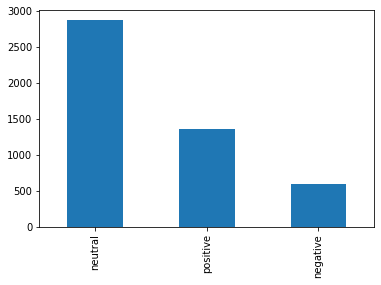

In [257]:
data['sentiment'].value_counts().plot(kind='bar')
plt.show()

In [258]:
X= data.sentence
y = data.sentiment
# neu = y[y == 'neutral'].index
# X= X.drop(neu)
# y = y.drop(neu)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=60, test_size=0.2)

In [259]:
X_train.shape, X_test.shape, X.shape

((3876,), (969,), (4845,))

In [260]:
neu_index = y_train[y_train == 'neutral'].index
pos_index = y_train[y_train == 'positive'].index
neg_index = y_train[y_train == 'negative'].index

In [262]:

# Down-sample neutral class
X_train_neu, y_train_neu = resample(X_train.loc[neu_index], y_train.loc[neu_index],
                                    n_samples=len(pos_index), replace=False,
                                    random_state=60)

# Up-sample negative class
X_train_neg, y_train_neg = resample(X_train.loc[neg_index], y_train.loc[neg_index],
                                    n_samples=len(pos_index), replace=True,
                                    random_state=60)

In [263]:
# Combine resampled classes
X_train_resample = X_train.loc[pos_index].append([X_train_neu, X_train_neg])
y_train_resample = y_train.loc[pos_index].append([y_train_neu, y_train_neg])

# Shuffle samples
X_train_resample, y_train_resample = shuffle(X_train_resample, y_train_resample, random_state=7)

# Display new class counts
print(y_train_resample.value_counts())

neutral     1090
negative    1090
positive    1090
Name: sentiment, dtype: int64


In [264]:
# X_train = X_train.loc[pos_index].append(X_train_neg)
# y_train = y_train.loc[pos_index].append(y_train_neg)
# X_train, y_train = shuffle(X_train, y_train, random_state=60)

In [265]:
y_test.value_counts()

neutral     575
positive    273
negative    121
Name: sentiment, dtype: int64

In [282]:
X_train_resample.shape, y_train_resample.shape

((3270,), (3270,))

# Prepare Data for model

In [296]:
# Remove Punctuation and assign integer to each word
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_resample)
X_train_seq = tokenizer.texts_to_sequences(X_train_resample)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [298]:
# Make sequences of equal length 
max_len = np.max([len(X_train_seq[i]) for i in range(len(X_train_seq))])
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_len)

In [299]:
X_train_seq.shape

(3270, 71)

In [300]:
# Convert sentiment values to one hot encoded for Keras model
le = LabelEncoder()
le.fit(y_train_resample)
y_train_seq = to_categorical(le.transform(y_train_resample))
y_test_seq = to_categorical(le.transform(y_test))

In [301]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

# EMBEDDINGS

In [16]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

--2021-03-21 03:31:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-21 03:31:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-21 03:31:05--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [302]:
dict_w2v = {}
with open('/content/glove.6B.100d.txt', 'r') as file:
    for line in file:
        tokens = line.split()
        word = tokens[0]
        vector = np.array(tokens[1:], dtype=np.float32)
        if vector.shape[0] == 100:
            dict_w2v[word] = vector
        else:
            print("There is issue with " + word)

In [286]:
print("dictionary size :" ,len(dict_w2v) )

dictionary size : 400000


In [303]:
words_found = set()
words_not_found = set()
for word in tokenizer.word_index:
    vec = dict_w2v.get(word)
    if vec is not None:
        words_found.add(word)
    else:
        words_not_found.add(word)
len(words_found), len(words_not_found), len(tokenizer.word_index)

(6187, 918, 7105)

In [304]:
EMBEDDING_DIM = 100
VOCAB_SIZE = len(tokenizer.word_index)
embedding_matrix = np.zeros((VOCAB_SIZE +1, EMBEDDING_DIM))

In [305]:
unk_cnt = 0
unk_set = set()
for word, i in tokenizer.word_index.items():
    emb_vector = dict_w2v.get(word)
    if emb_vector is not None:
        embedding_matrix[i] = emb_vector
    else:
        unk_cnt += 1
        unk_set.add(word)
unk_cnt

918

In [306]:
X_train_seq.shape, y_train_seq.shape

((3270, 71), (3270, 3))

Epoch 1/100
52/52 [==============================] - 4s 30ms/step - loss: 1.0826 - recall: 0.1917 - val_loss: 0.8197 - val_recall: 0.4933
Epoch 2/100
52/52 [==============================] - 1s 17ms/step - loss: 0.9074 - recall: 0.3984 - val_loss: 0.8047 - val_recall: 0.4871
Epoch 3/100
52/52 [==============================] - 1s 17ms/step - loss: 0.8247 - recall: 0.5045 - val_loss: 0.7487 - val_recall: 0.5666
Epoch 4/100
52/52 [==============================] - 1s 17ms/step - loss: 0.7710 - recall: 0.5631 - val_loss: 0.6525 - val_recall: 0.6574
Epoch 5/100
52/52 [==============================] - 1s 17ms/step - loss: 0.7074 - recall: 0.6210 - val_loss: 0.7063 - val_recall: 0.6192
Epoch 6/100
52/52 [==============================] - 1s 17ms/step - loss: 0.6734 - recall: 0.6615 - val_loss: 0.6345 - val_recall: 0.6749
Epoch 7/100
52/52 [==============================] - 1s 17ms/step - loss: 0.6300 - recall: 0.6827 - val_loss: 0.7091 - val_recall: 0.6471
Epoch 8/100
52/52 [===============

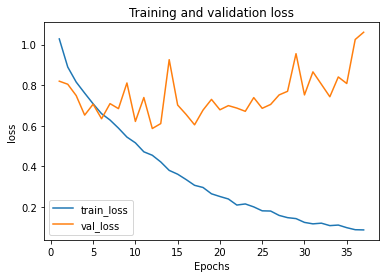

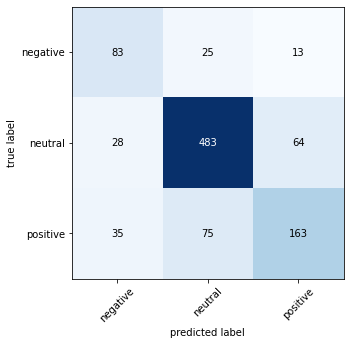

          1-Precision  2-Recall  3-F1 score  4-Support
negative  0.568        0.686     0.622       121      
neutral   0.828        0.840     0.834       575      
positive  0.679        0.597     0.635       273      


In [307]:
np.random.seed(60)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(VOCAB_SIZE +1, EMBEDDING_DIM, weights=[embedding_matrix],input_length=max_len, trainable=False))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200, return_sequences=True), merge_mode='concat')) #{"sum", "mul", "ave", "concat", None}
model.add(Dropout(0.25))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[ 
                                                                            #  'Precision',                                                        
                                                                             'Recall',
                                                                            #  'accuracy'
                                                                             ])
# model.summary()

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
mcp_save = ModelCheckpoint('./model.hdf5', save_best_only=True, monitor='val_loss', mode='min')


batch_size = 64
epochs = 100


history = model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=batch_size,verbose=1, validation_data=(X_test_seq, y_test_seq), 
                    callbacks=[early_stopping, mcp_save], shuffle=False)


%matplotlib inline
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history, 'loss')


model.load_weights('model.hdf5')

preds = model.predict(X_test_seq, batch_size=batch_size)
true_y = np.argmax(y_test_seq, axis=1)
pred_y = np.argmax(preds, axis=1)

c_mat = confusion_matrix(true_y, pred_y)
plot_confusion_matrix(c_mat, cmap='Blues', class_names = le.classes_, figsize=(5, 5))
plt.show()

p, r, f1, s = precision_recall_fscore_support(true_y, pred_y, average=None)

# Print precision, recall, f1 score and support
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=le.classes_)

# Print precision, recall, f1 score and support
print(results.round(decimals=3))

# Prepare NEPSE DATA

In [308]:
indices = pd.read_csv('/content/Nepse Indices - Sheet1.csv', header=1)
indices.columns= ['no_name', 'date', 'index', 'abs_change', 'pct_change']
indices['date'] = pd.to_datetime(indices['date'])
indices = indices[indices['date'] < '2019-07-06']

In [309]:
news_df = pd.read_csv('/content/years_combined_df.csv')
news_df['date'] = pd.to_datetime(news_df['date'])
news_df = news_df[news_df['date'] >= '2014-02-02']
news_df.reset_index(drop=True, inplace=True)
print("Total News Data Scraped :", news_df.shape[0])

Total News Data Scraped : 9802


In [310]:
news_df = news_df[news_df['date'].isin(indices['date'])].reset_index(drop=True)
print("Total News Data as per Nepse indices trading days ", news_df.shape[0])

Total News Data as per Nepse indices trading days  6307


In [311]:
print("Total NEPSE Index days: ", indices.shape[0])

Total NEPSE Index days:  1248


In [312]:
indices = indices[indices['date'].isin(news_df['date'])].reset_index(drop=True)
print("Total NEPSE index matched with News date:", indices.shape[0])

Total NEPSE index matched with News date: 1238


In [313]:
indices['pct_change'] = indices['pct_change'].str.replace('%', '').astype(float)

In [314]:
indices['target'] = np.where(indices['pct_change'] < 0 , 0, 1)

In [315]:
def prepare_and_predict_news(series, pad_max_len, batch_size):

    news = tokenizer.texts_to_sequences(series)
    news = pad_sequences(news, pad_max_len)
    news = model.predict(news, batch_size=batch_size)
    return news

In [316]:
news_sentiment = prepare_and_predict_news(news_df['content'], pad_max_len=max_len, batch_size=batch_size)
# news_df['pred_glove_300'] = np.argmax(news_sentiment, axis=1)

array(['negative', 'neutral', 'positive'], dtype=object)

In [318]:
news_sentiment_df = pd.DataFrame(news_sentiment, columns=le.classes_)

In [319]:
final_df = pd.concat([news_df, news_sentiment_df], axis=1)

In [321]:
pd.set_option('max_colwidth', -1)
final_df[['content', 'negative', 'neutral','positive']].head(15)

,content,negative,neutral,positive
0,Nepal Stock Exchange (Nepse) slid 2.22 points to close at 781.46 points last week.,0.958482,0.008615,0.032902
1,Moffat Nyirenda is president of Round Table International.,0.045039,0.833332,0.121629
2,The government has stopped monitoring of shops dealing in readymade garment and shoes although previous inspections have revealed rampant malpractices.,0.539504,0.369079,0.091416
3,The Ministry of Industry (MoI) is preparing to recommend the Cabinet to declare Pokhara-based Fulbari Resort and Chitwan-based Chitwan Wildlife Lodge,0.004101,0.844081,0.151818
4,The delivery of Chinese aircraft for Nepal Airlines Corporation (NAC) will be delayed by a month.,0.310606,0.549876,0.139518
5,"Talking about pricey threads, the domestic market will soon get to witness the launch of a suiting brand costing upwards of Rs 300,000.",0.002726,0.937742,0.059532
6,Cross-border trade with India via Janakpur has come to a complete halt after Janakpur Railway suspended its Janakpur-Jayanagar service.,0.024088,0.614093,0.361818
7,Fifty-seven percent work has been completed on the much-prioritised 456-MW Upper Tamakoshi Hydropower Project (UTHP).,0.006937,0.791029,0.202034
8,The government is not in a position to assure the quality of cooking oil due to the lack of technology to determine the quantity of different components of the oil.,0.006689,0.873132,0.120179
9,NIDC Development Bank won’t be able to hand out the promised 133 percent bonus shares as it has not issued public shares yet.,0.005013,0.947904,0.047083


In [322]:
df = pd.merge(final_df, indices, left_on='date', right_on='date')

In [323]:
indices['negative_mean'] = df.groupby('date')['negative'].apply(np.mean).reset_index(drop=True)
indices['neutral_mean'] = df.groupby('date')['neutral'].apply(np.mean).reset_index(drop=True)
indices['positive_mean'] = df.groupby('date')['positive'].apply(np.mean).reset_index(drop=True)

In [324]:
features = ['negative_mean', 'neutral_mean','positive_mean']

In [325]:
validation_df = indices[indices['date'] > '2018-12-31']
train_df = indices[indices['date'] <= '2018-12-31']

In [326]:
Xtrain, ytrain = train_df[features], train_df['target']

In [327]:
Xtest, ytest = validation_df[features], validation_df['target']

In [328]:
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((1117, 3), (1117,), (121, 3), (121,))

In [329]:
def accuracy_metrics(preds, dtrain):

    labels = dtrain.get_label()
    # print(labels)
    # preds = preds.reshape(5, -1).T
    preds = np.round(preds)
    # f_score = f1_score(labels , preds,  average = 'weighted')
    acc_score = accuracy_score(labels, preds)
    return 'acc_score', acc_score, True

In [330]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(train_df[features], train_df['target'],
#                                                 stratify=train_df['target'],
#                                                 random_state=60, test_size=0.2 )


params = {
'num_leaves': 4,
'objective': 'binary',
'max_depth': 4,
'learning_rate': 0.05,
"boosting_type": "gbdt",
"bagging_seed": 11,
# "metric": 'auc',
"verbosity": -1,
'random_state': 60
}
import lightgbm as lgb
tr_data = lgb.Dataset(Xtrain, label=ytrain)
va_data = lgb.Dataset(Xtest, label=ytest)

model = lgb.train(
        params, 
        tr_data,
        num_boost_round=5000,   
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=50,
        feval=accuracy_metrics,   
        feature_name=features,
        verbose_eval=10
    )


Training until validation scores don't improve for 50 rounds.
[10]	training's binary_logloss: 0.687078	training's acc_score: 0.537153	valid_1's binary_logloss: 0.693196	valid_1's acc_score: 0.487603
[20]	training's binary_logloss: 0.682872	training's acc_score: 0.567592	valid_1's binary_logloss: 0.691304	valid_1's acc_score: 0.561983
[30]	training's binary_logloss: 0.679167	training's acc_score: 0.572963	valid_1's binary_logloss: 0.687153	valid_1's acc_score: 0.570248
[40]	training's binary_logloss: 0.675931	training's acc_score: 0.580125	valid_1's binary_logloss: 0.686151	valid_1's acc_score: 0.595041
[50]	training's binary_logloss: 0.672707	training's acc_score: 0.597135	valid_1's binary_logloss: 0.685507	valid_1's acc_score: 0.628099
[60]	training's binary_logloss: 0.67012	training's acc_score: 0.606088	valid_1's binary_logloss: 0.686589	valid_1's acc_score: 0.528926
[70]	training's binary_logloss: 0.667487	training's acc_score: 0.606983	valid_1's binary_logloss: 0.684844	valid_1's 

In [331]:
model.best_iteration

49

In [142]:
# !pip install optuna

In [361]:
import optuna
from sklearn.metrics import roc_auc_score
from google.colab import output
# lgb_train = lgb.Dataset(Xt, Yt)
# lgb_eval = lgb.Dataset(Xv, Yv)
def objective(trial):    
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 2, 512),
            'boosting_type': 'gbdt',
            'objective': 'binary',
            # 'metric': 'auc',
            'bagging_seed':60,
            'max_depth': trial.suggest_int('max_depth', 1, 16),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 16),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 8),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 80),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
            'learning_rate' : trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'max_bin': trial.suggest_int('max_bin', 4, 900),
            'early_stopping_rounds': 50,
            'random_state':60 
            }

    model = lgb.train(params, tr_data, valid_sets=[tr_data, va_data], verbose_eval=None, num_boost_round=5000, feval=accuracy_metrics)
    score = model.best_score['valid_1']['acc_score']
    # val_pred = model.predict(Xtest)
    # score = accuracy_score(ytest, np.round(val_pred))
    print(score)
    # output.clear()
    # print(f"AUC = {score}")
    return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

In [371]:
study.best_params

{'bagging_fraction': 0.6179823081964898,
 'bagging_freq': 6,
 'feature_fraction': 0.8231954406977613,
 'lambda_l1': 4.7137947943331354e-05,
 'lambda_l2': 1.034109245314662e-06,
 'learning_rate': 0.4654640475316162,
 'max_bin': 746,
 'max_depth': 6,
 'min_child_samples': 57,
 'min_child_weight': 6,
 'num_leaves': 504}

In [357]:
ytest.value_counts()

0    62
1    59
Name: target, dtype: int64

In [352]:
Xtrain, ytrain = train_df[features], train_df['target']
Xtest, ytest = validation_df[features], validation_df['target']

In [372]:

import lightgbm as lgb
tr_data = lgb.Dataset(Xtrain, label=ytrain)
va_data = lgb.Dataset(Xtest, label=ytest)
params = {
'objective': 'binary',
"boosting_type": "gbdt",
"verbosity": -1,
'random_state': 60,
'bagging_seed':60,
 'bagging_fraction': 0.6179823081964898,
 'bagging_freq': 6,
 'feature_fraction': 0.8231954406977613,
 'lambda_l1': 4.7137947943331354e-05,
 'lambda_l2': 1.034109245314662e-06,
 'learning_rate': 0.4654640475316162,
 'max_bin': 746,
 'max_depth': 6,
 'min_child_samples': 57,
 'min_child_weight': 6,
 'num_leaves': 504
}



model = lgb.train(
        params, 
        tr_data,
        num_boost_round=5000,   
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=50,   
        feature_name=features,
        verbose_eval=10, 
        feval = accuracy_metrics
    )


Training until validation scores don't improve for 50 rounds.
[10]	training's binary_logloss: 0.662744	training's acc_score: 0.606088	valid_1's binary_logloss: 0.688826	valid_1's acc_score: 0.578512
[20]	training's binary_logloss: 0.640291	training's acc_score: 0.638317	valid_1's binary_logloss: 0.684331	valid_1's acc_score: 0.586777
[30]	training's binary_logloss: 0.62469	training's acc_score: 0.646374	valid_1's binary_logloss: 0.694049	valid_1's acc_score: 0.561983
[40]	training's binary_logloss: 0.603707	training's acc_score: 0.686661	valid_1's binary_logloss: 0.657144	valid_1's acc_score: 0.619835
[50]	training's binary_logloss: 0.58325	training's acc_score: 0.709937	valid_1's binary_logloss: 0.675603	valid_1's acc_score: 0.619835
[60]	training's binary_logloss: 0.572964	training's acc_score: 0.703671	valid_1's binary_logloss: 0.675323	valid_1's acc_score: 0.710744
[70]	training's binary_logloss: 0.561572	training's acc_score: 0.721576	valid_1's binary_logloss: 0.662897	valid_1's a

In [373]:
model.best_score

defaultdict(dict,
            {'training': {'acc_score': 0.7036705461056401,
              'binary_logloss': 0.5729637281907028},
             'valid_1': {'acc_score': 0.7107438016528925,
              'binary_logloss': 0.6753228199536845}})

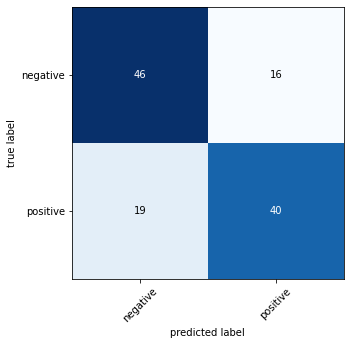

          1-Precision  2-Recall  3-F1 score  4-Support
negative  0.708        0.742     0.724       62       
positive  0.714        0.678     0.696       59       
0.6697648988518317
0.7107438016528925


In [375]:
preds = model.predict(Xtest, model.best_iteration)
c_mat = confusion_matrix(ytest, np.round(preds))
plot_confusion_matrix(c_mat, cmap='Blues', class_names = ['negative', 'positive'], figsize=(5, 5))
plt.show()

p, r, f1, s = precision_recall_fscore_support(ytest, np.round(preds), average=None)

results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=['negative', 'positive'])
print(results.round(decimals=3))
print(roc_auc_score(ytest, preds))
print(accuracy_score(ytest, np.round(preds)))